<a href="https://colab.research.google.com/github/dinithprimal/GenerativeAI_HadnsOn/blob/main/Data_Generation_with_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

### Parameter Settings

In [2]:
# latent_dims = 10
num_epochs = 20
batch_size = 128
learning_rate = 2e-4
use_gpu = True

### MNIST Data Loading

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 140858216.71it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105795365.79it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38563231.63it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20729628.69it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 143554607.63it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105795365.79it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49758552.09it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5256768.42it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



### GAN Definition

We use a convolutional generater and discriminator, which fenerally gives better performance than fully connected versions that have the same number of parameters.

kernel size 4 is used to avoid biasing problems

In [4]:
# Generator

class Generator(nn.Module):
  def __init__(self, d=128):
    super(Generator, self).__init__()
    self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
    self.deconv1_bn = nn.BatchNorm2d(d*8)
    self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(d*4)
    self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(d*2)
    self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(d)
    self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

  def forward(self, input):
    # x = F.relu(self.deconv1(input))
    x = F.relu(self.deconv1_bn(self.deconv1(input)))
    x = F.relu(self.deconv2_bn(self.deconv2(x)))
    x = F.relu(self.deconv3_bn(self.deconv3(x)))
    x = F.relu(self.deconv4_bn(self.deconv4(x)))
    x = torch.tanh(self.deconv5(x))

    return x

# Discriminator

class Discriminator(nn.Module):
  def __init__(self, d=128):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
    self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(d*2)
    self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(d*4)
    self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(d*8)
    self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

  def forward(self, input):
    x = F.leaky_relu(self.conv1(input), 0.2)
    x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
    x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
    x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
    x = torch.sigmoid(self.conv5(x))

    return x

generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' %(num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


### Train GAN

In [6]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong mimentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing betal (the exponential decay for the
# gradient moving average in [0, 1], lower is daster decay) from the default 0.9
# to 0.5 allows for quicker reactions.

gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')

for epoch in range(num_epochs):
  gen_loss_avg.append(0)
  disc_loss_avg.append(0)
  num_batches = 0

  for image_batch, _ in train_dataloader:

    # get detaset image and create real and fake labels for use in the loss
    image_batch = image_batch.to(device)
    label_real = torch.ones(image_batch.size(0), device=device)
    label_fake = torch.zeros(image_batch.size(0), device=device)

    # generate a batch of images from samples of the latent prior
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)

    # Train discriminator to correctly classify real and fake
    # (detach the computational graph of the generator and the discriminator,
    # so that gradients are not backpropagated into the generator)
    real_pred = discriminator(image_batch).squeeze()
    fake_pred = discriminator(fake_image_batch.detach()).squeeze()
    disc_loss = 0.5 * (
        F.binary_cross_entropy(real_pred, label_real) +
        F.binary_cross_entropy(fake_pred, label_fake)
    )

    disc_optimizer.zero_grad()
    disc_loss.backward()
    disc_optimizer.step()

    # train generator to output an image that is classified as real
    fake_pred = discriminator(fake_image_batch).squeeze()
    gen_loss = F.binary_cross_entropy(fake_pred, label_real)

    gen_optimizer.zero_grad()
    gen_loss.backward()
    gen_optimizer.step()

    gen_loss_avg[-1] += gen_loss.item()
    disc_loss_avg[-1] += disc_loss.item()
    num_batches += 1

  gen_loss_avg[-1] /= num_batches
  disc_loss_avg[-1] /= num_batches
  print('Epochs [%d / %d] average loss generator vs. discrim.: %f vs. %f'
        %(epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Training...
Epochs [1 / 20] average loss generator vs. discrim.: 6.180842 vs. 0.699171
Epochs [2 / 20] average loss generator vs. discrim.: 1.783334 vs. 0.537233
Epochs [3 / 20] average loss generator vs. discrim.: 5.134963 vs. 0.210264
Epochs [4 / 20] average loss generator vs. discrim.: 2.892674 vs. 0.351805
Epochs [5 / 20] average loss generator vs. discrim.: 7.975524 vs. 0.002072
Epochs [6 / 20] average loss generator vs. discrim.: 8.645412 vs. 0.000371
Epochs [7 / 20] average loss generator vs. discrim.: 9.606626 vs. 0.000077
Epochs [8 / 20] average loss generator vs. discrim.: 10.658025 vs. 0.000028
Epochs [9 / 20] average loss generator vs. discrim.: 10.912210 vs. 0.000036
Epochs [10 / 20] average loss generator vs. discrim.: 5.117734 vs. 0.338146
Epochs [11 / 20] average loss generator vs. discrim.: 3.217555 vs. 0.262048
Epochs [12 / 20] average loss generator vs. discrim.: 5.593109 vs. 0.203805
Epochs [13 / 20] average loss generator vs. discrim.: 8.081266 vs. 0.001043
Epochs 

### Plot Training Curves

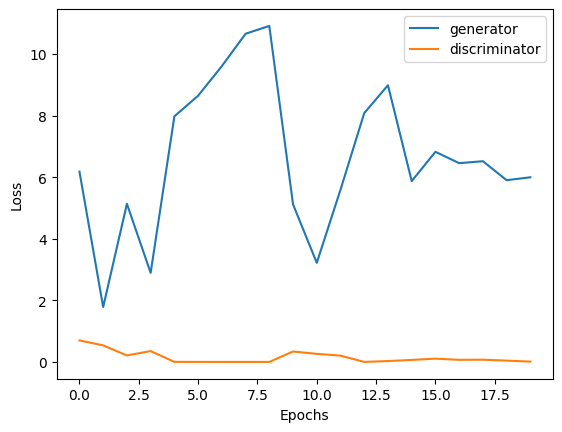

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Sample Latent Vector from Prior (GAN as Generator)

GAN usually generate higher-quality results than VAEs or plain Autoencoders

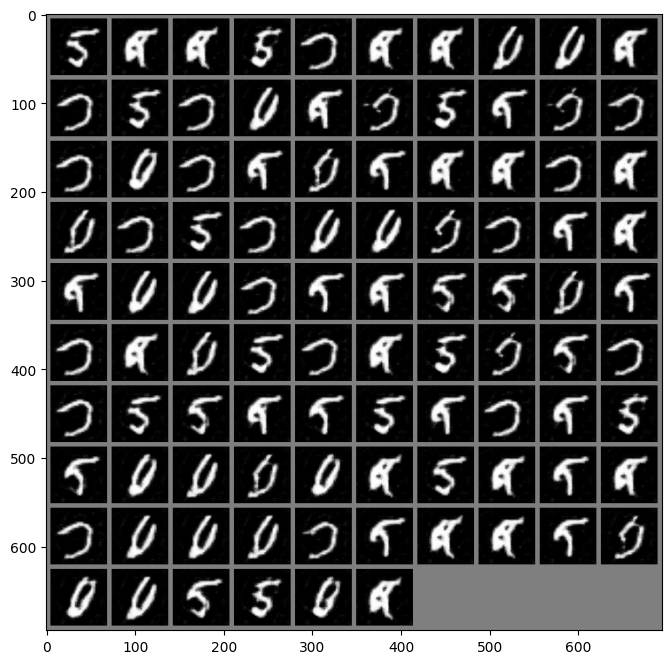

In [9]:
import numpy as np

plt.ion()

import torchvision.utils

generator.eval()

def to_img(x):
  x = 0.5 * (x + 1)
  x = x.clamp(0, 1)
  return x

def show_image(img):
  img = to_img(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():

  # sample latent vectors from the standard normal distribution
  latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
  fake_image_batch = generator(latent)
  fake_image_batch = fake_image_batch.cpu()

  fig, ax = plt.subplots(figsize=(8, 8))
  show_image(torchvision.utils.make_grid(fake_image_batch.data[:100], 10, 5))
  plt.show()